In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import json
import os
import sys

from tqdm import tqdm
src_dir = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'src')
sys.path.append(src_dir)

In [2]:
def remove_specific_leading_chars(input_string):
    import re
    # Remove leading commas
    input_string = re.sub(r'^,+', '', input_string)
    # Remove numbers followed by a comma
    return re.sub(r'^\d+,+', '', input_string)

In [3]:
orig_datasets = {}
suffix = '.jsonl'
dataset_dir = "/Users/cherian/Projects/conformal-safety/data/MedLFQAv2"
for path in os.listdir(dataset_dir):
    dataset_name = path[:-len(suffix)]
    with open(os.path.join(dataset_dir, path), 'r') as fp:
        orig_datasets[dataset_name] = [json.loads(line) for line in fp.readlines()]

dataset_lookup = {}
for name, data in orig_datasets.items():
    for dat in data:
        dataset_lookup[dat['Question']] = name

data_path = "/Users/cherian/Projects/conformal-safety/data"
dataset_path = os.path.join(data_path, "medlfqa_dataset.pkl")
freq_path = os.path.join(data_path, "medlfqa_frequencies.npz")
logprob_path = os.path.join(data_path, "medlfqa_logprobs.npz")
selfeval_path = os.path.join(data_path, "medlfqa_selfevals.npz")

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)


## HARD CODED FIX FOR REDUNDANT PROMPT...which has atomic_facts assigned to the wrong redundancy
dataset[1132]['atomic_facts'] = dataset[1048]['atomic_facts']

frequencies = np.load(freq_path)
logprobs = np.load(logprob_path)
selfevals = np.load(selfeval_path)

drop_prompts = []
for k in frequencies:
    if frequencies[k].ndim != 1:
        drop_prompts.append(k)
    elif np.allclose(selfevals[k], -1):
        drop_prompts.append(k)
    elif k not in logprobs:
        drop_prompts.append(k)
    elif remove_specific_leading_chars(k).strip() not in dataset_lookup:
        drop_prompts.append(k)

# drop and match ordering of dataset
dataset = [dat for dat in dataset if dat['prompt'] not in drop_prompts]
full_dataset = dataset
prompts_to_keep = [dat['prompt'] for dat in dataset]
names_to_keep = [p.split('about')[-1].strip()[:-1] for p in prompts_to_keep]

frequencies_arr = [frequencies[p] for p in prompts_to_keep]
selfevals_arr = [selfevals[p] for p in prompts_to_keep]
logprobs_arr = [logprobs[p] for p in prompts_to_keep]
annotations_arr = [np.asarray([af["is_supported"] for af in dat["atomic_facts"]]) for dat in dataset]
ordinal_arr = [np.arange(len(f)) for f in frequencies_arr]

print(len(frequencies_arr), len(selfevals_arr), len(dataset), len(annotations_arr))

4805 4805 4805 4805


In [4]:
# get prompt-level features


# names of datasets
dataset_arr = [dataset_lookup[remove_specific_leading_chars(p).strip()] for p in prompts_to_keep]
dataset_dummies = pd.get_dummies(dataset_arr)
dataset_names = [name[:-3] if name.endswith("_qa") else name for name in dataset_dummies.columns]

# length of response
response_len_arr = [len(dat['response']) for dat in dataset]
response_len_arr = np.asarray(response_len_arr).reshape(-1,1)

# length of prompt
prompt_len_arr = [len(remove_specific_leading_chars(dat['prompt']).strip()) for dat in dataset]
prompt_len_arr = np.asarray(prompt_len_arr).reshape(-1,1)

# mean (exponentiated) logprob 
logprobs_mean_arr = [np.mean(arr) for arr in logprobs_arr]
logprobs_mean_arr = np.asarray(logprobs_mean_arr).reshape(-1,1)

# std (exponentiated) logprob
logprobs_std_arr = [np.std(arr) for arr in logprobs_arr]
logprobs_std_arr = np.asarray(logprobs_std_arr).reshape(-1,1)

z_ones = np.ones((len(frequencies_arr), 1))
z_arr = np.concatenate((z_ones, response_len_arr, prompt_len_arr, logprobs_mean_arr, logprobs_std_arr), axis=1)
z_dummies = dataset_dummies.to_numpy()

z_arr_dummies = np.concatenate((z_arr, z_dummies[:,:-1]), axis=1)

print(len(dataset_arr), len(response_len_arr), len(prompt_len_arr), len(logprobs_mean_arr), len(logprobs_std_arr))
dataset_dummies

4805 4805 4805 4805 4805


,healthsearch_qa,kqa_golden,kqa_silver_wogold,live_qa,medication_qa
0,True,False,False,False,False
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
4800,True,False,False,False,False
4801,False,False,False,False,True
4802,True,False,False,False,False
4803,False,False,False,False,True


In [5]:
from typing import List
from conditionalconformal import CondConf

def split_dataset(dataset, rng, train_frac = 0.8):
    x, y = dataset
    ind = np.arange(len(x))
    rng.shuffle(ind)
    train_num = int(train_frac * len(x))
    train_ind = ind[0:train_num]
    calib_ind = ind[train_num:]

    x_train = [x[i] for i in train_ind]
    y_train = [y[i] for i in train_ind]

    x_calib = [x[i] for i in calib_ind]
    y_calib = [y[i] for i in calib_ind]
    return (x_train, y_train), (x_calib, y_calib), train_ind, calib_ind
    
def score_func(
    claim_scores : List[np.ndarray],
    annotations : List[np.ndarray],
    method : str = "max"
):
    if method == "max":
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            scores[i] = np.max(cs[~a]) if np.sum(~a) >= 1 else min_score
    if isinstance(method, int):
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            scores[i] = np.sort(cs[~a])[::-1][method] if np.sum(~a) > method else min_score
    return scores

def split_threshold(
    conf_scores : np.ndarray,
    quantile
):
    n = len(conf_scores)
    threshold = np.sort(conf_scores)[int(np.ceil(quantile * (n + 1)))]
    return threshold

def get_retained_claims(claim_scores, thresholds):
    claims_retained = []
    for cs, t in zip(claim_scores, thresholds):
        claims_retained.append(np.mean(cs > t))
    return claims_retained

def get_retained_claim_indices(claim_scores, thresholds):
    claims_retained = []
    for cs, t in zip(claim_scores, thresholds):
        claims_retained.append(np.where(cs > t)[0])
    return claims_retained

def get_validity(claim_scores, annotations, threshold, method):
    conf_scores = score_func(claim_scores, annotations, method)
    validity = conf_scores <= threshold
    return validity

def run_split_conformal(x_arr, y_arr, method, quantile):
    conf_scores = score_func(x_arr, y_arr, method=k)
    threshold = split_threshold(conf_scores, quantile)
    return conf_scores, threshold


In [6]:


rng = np.random.default_rng(seed=0)
rand_scores = rng.standard_normal(size=(len(np.concatenate(selfevals_arr)),))

print(np.corrcoef(np.concatenate(frequencies_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(np.concatenate(logprobs_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(np.concatenate(selfevals_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(np.concatenate(ordinal_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(rand_scores, np.concatenate(annotations_arr)))

[[1.         0.29924037]
 [0.29924037 1.        ]]
[[1.        0.3700479]
 [0.3700479 1.       ]]
[[1.         0.16687224]
 [0.16687224 1.        ]]
[[1.         0.03922197]
 [0.03922197 1.        ]]
[[ 1.         -0.00389273]
 [-0.00389273  1.        ]]


In [7]:
def run_coverage_trial(x_arr, y_arr, z_arr, rng, method, quantile):
    data_calib, data_test, idx_calib, idx_test = split_dataset((x_arr, y_arr), rng, train_frac=0.7)
    scores_calib = score_func(*data_calib, method=method)
    scores_test = score_func(*data_test, method=method)
    
    condconf = CondConf(lambda x,y: y, lambda x: x)
    condconf.setup_problem(z_arr[idx_calib], scores_calib)
    
    # scores, threshold = run_split_conformal(*data_calib, method=method, quantile=quantile)
    valid_inds = []
    claim_perc = []
    for i, j in enumerate(idx_test):
        try:
            threshold = condconf.predict(quantile, z_arr[j].reshape(1,-1), lambda c, x: c, randomize=True)
        except:
            print("hmmm")
            threshold = [np.inf]
        valid_inds.append(threshold >= scores_test[i])
        claim_perc.append(get_retained_claims([data_test[0][i]], threshold)[0])
                          
    valid_inds = np.asarray(valid_inds).flatten()
    claim_perc = np.asarray(claim_perc).flatten()

    # valid_inds = get_validity(*data_calib, threshold, method)
    all_covs = np.zeros((1,))
    marginal_cov = np.mean(valid_inds)
    all_covs[0] = marginal_cov

    all_claims = np.zeros((1,))
    all_claims[0] = np.mean(claim_perc)

    dataset_covs = np.zeros(len(dataset_names))
    dataset_claims = np.zeros(len(dataset_names))

    for d_idx in range(len(dataset_names)):
        dataset_cov = np.sum(dataset_dummies.to_numpy()[idx_test,d_idx] * valid_inds) / np.sum(dataset_dummies.to_numpy()[idx_test,d_idx])
        dataset_covs[d_idx] = dataset_cov
        dataset_perc = np.sum(dataset_dummies.to_numpy()[idx_test,d_idx] * claim_perc) / np.sum(dataset_dummies.to_numpy()[idx_test,d_idx])
        dataset_claims[d_idx] = dataset_perc
    
    return np.concatenate((all_covs, dataset_covs)), np.concatenate((all_claims, dataset_claims))

In [8]:
# selfevals_arr another option
n_trials = 50
all_covs = np.zeros((n_trials, 1 + len(dataset_names)))
all_claims = np.zeros((n_trials, 1 + len(dataset_names)))

rng = np.random.default_rng(seed=0)
k = 0
quantile = 0.9


frequencies_arr_jitter = [freq + rng.uniform(low=0, high=1e-3, size=freq.shape) for freq in frequencies_arr]
rng = np.random.default_rng(seed=1)
for trial in tqdm(range(n_trials)):
    all_covs[trial], all_claims[trial] = run_coverage_trial(frequencies_arr_jitter, annotations_arr, z_arr_dummies, rng, k, quantile)

 16%|████████████▋                                                                  | 8/50 [00:20<01:50,  2.63s/it]

hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm


 18%|██████████████▏                                                                | 9/50 [00:20<01:26,  2.11s/it]

hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm


100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [02:03<00:00,  2.47s/it]


In [9]:
n_trials = 50
all_covs_mh = np.zeros((n_trials, 1 + len(dataset_names)))
all_claims_mh = np.zeros((n_trials, 1 + len(dataset_names)))

rng = np.random.default_rng(seed=0)
k = 0
quantile = 0.9

frequencies_arr_jitter = [freq + rng.uniform(low=0, high=1e-3, size=freq.shape) for freq in frequencies_arr]
rng = np.random.default_rng(seed=1)
for trial in tqdm(range(n_trials)):
    all_covs_mh[trial], all_claims_mh[trial] = run_coverage_trial(frequencies_arr_jitter, annotations_arr, z_ones, rng, k, quantile)

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.38s/it]


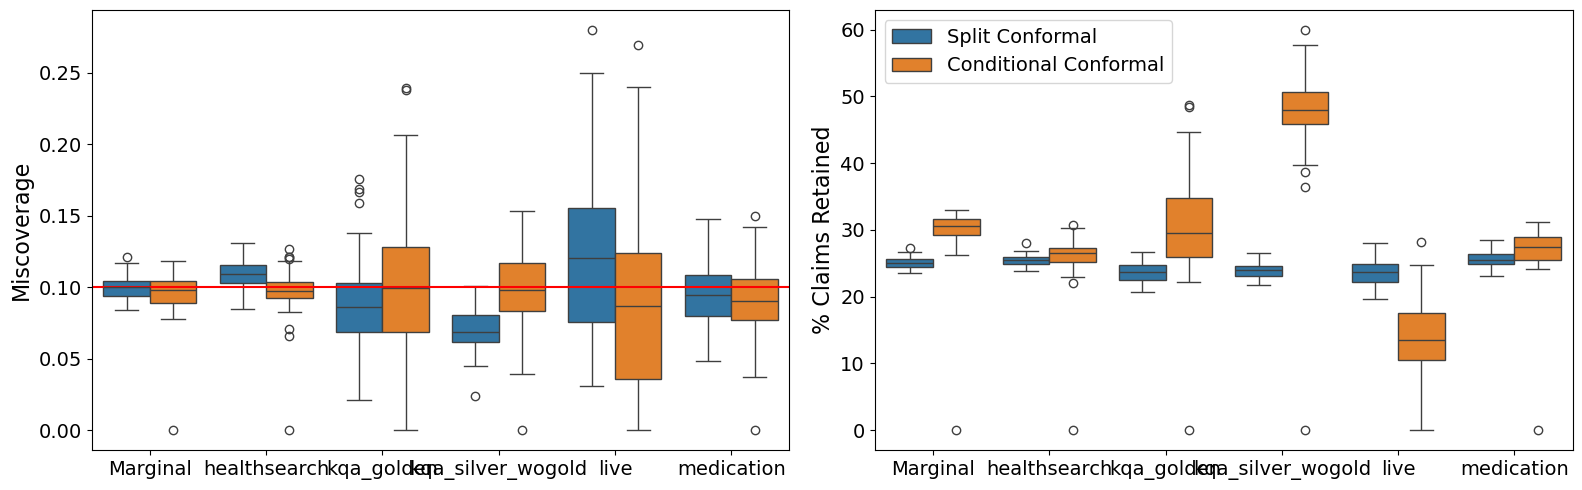

In [10]:
# Create a DataFrame for each method
names = ["Marginal"] + dataset_names
indices_to_plot = np.arange(len(names))

names = [names[i] for i in indices_to_plot]

df1 = pd.DataFrame(1 - all_covs_mh[:,indices_to_plot], columns=names)
df2 = pd.DataFrame(1 - all_covs[:,indices_to_plot], columns=names)

# Add a column to identify the method
df1['Method'] = 'Split Conformal'
df2['Method'] = 'Conditional Conformal'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted_cov = df.melt(id_vars='Method', var_name='Dataset', value_name='Miscoverage')

df1 = pd.DataFrame(all_claims_mh[:,indices_to_plot] * 100, columns=names)
df2 = pd.DataFrame(all_claims[:,indices_to_plot] * 100, columns=names)

# Add a column to identify the method
df1['Method'] = 'Split Conformal'
df2['Method'] = 'Conditional Conformal'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted_claim = df.melt(id_vars='Method', var_name='Dataset', value_name='% Claims Retained')

# Create the boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
plot_ = sns.boxplot(x='Dataset', y='Miscoverage', hue='Method', data=df_melted_cov, ax=ax1, legend=False)
ax1.axhline(0.1, color='red')
ax1.set_xlabel("")
ax1.set_ylabel("Miscoverage", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

sns.boxplot(x='Dataset', y='% Claims Retained', hue='Method', data=df_melted_claim, ax=ax2)
ax2.legend(title="", fontsize=14)
ax2.set_xlabel("")
# ax2.axhline(80, color='red')
ax2.set_ylabel("% Claims Retained", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
# Customize the plot
# plt.legend()
plt.tight_layout()
# plt.savefig("figures/medlfqa_claim_cov_comparison.pdf")

In [13]:
## now I should try to estimate the alpha at which the conditional conformal method retains 70% of the claims
rng = np.random.default_rng(seed=0)
k = 0

dataset = (frequencies_arr_jitter, annotations_arr)
# split dataset
data_alpha, data_conf, ind_alpha, ind_conf = split_dataset(dataset, rng, train_frac=0.1)


phi_alpha = lambda x: x #np.concatenate((x, x[:,3:]**2, x[:,3:]**3), axis=1)

# use data alpha to estimate critical alpha for which fact retention goal is achieved
data_calib, data_test, ind_calib, ind_test = split_dataset(data_alpha, rng, train_frac=0.5)
z_calib = z_arr[ind_calib]
z_test = z_arr[ind_test]

scores_calib = score_func(*data_calib, method=k)

x_test, y_test = data_test
n_grid = 50
percents = np.empty((n_grid, len(x_test)))

condconf = CondConf(lambda x,y: y, phi_alpha)
condconf.setup_problem(z_calib, scores_calib)

quantile_grid = np.linspace(0.01, 0.99, 50)
i = 0
for q in tqdm(quantile_grid):
    perc_q = []
    for x_t, z_t in zip(x_test, z_test):
        cutoff = condconf.predict(quantile=q, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=False)
        perc_q.append(get_retained_claims([x_t], cutoff)[0])
    percents[i] = perc_q
    i += 1 


perc_booleans = percents >= 0.5

first_violating_indices = np.argmax(~perc_booleans, axis=0) - 1
first_violating_indices[~np.any(~perc_booleans, axis=0)] = -1  # Use -1 to indicate no False found

max_quantiles = quantile_grid[first_violating_indices]

  4%|████▊                                                                                                                    | 2/50 [00:06<02:40,  3.34s/it]


KeyboardInterrupt: 

(240, 1) (240,)


Text(0, 0.5, '$\\alpha^*$')

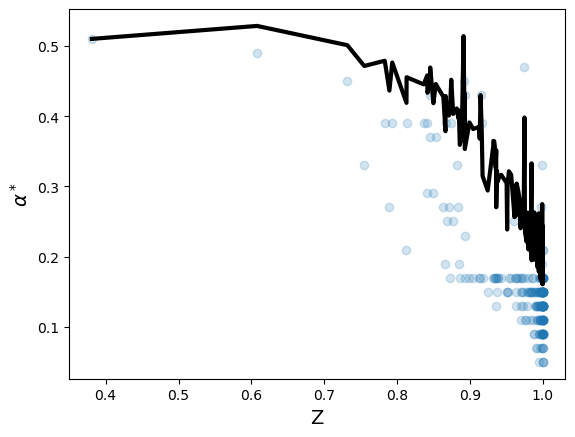

In [12]:
condconf_alpha = CondConf(score_fn = lambda x, y: y, Phi_fn = phi_alpha)
condconf_alpha.setup_problem(z_test, max_quantiles)
_, primals = condconf_alpha._get_calibration_solution(quantile=0.05)

quantile_fn = lambda x: np.clip(phi_alpha(x) @ primals, a_min=0.01, a_max=0.99)
z_to_plot = phi_alpha(z_test)[:,-2] 

sorted_ind = np.argsort(z_to_plot)

plt.plot(z_to_plot[sorted_ind],1 - quantile_fn(z_test)[sorted_ind], color='black', linewidth=3)
print(quantile_fn(z_test).shape, max_quantiles.shape)
plt.scatter(z_to_plot, 1 - max_quantiles, alpha=0.2)
# plt.xscale("log")
plt.xlabel("Z", fontsize=14)
plt.ylabel(r"$\alpha^*$", fontsize=14)
# plt.savefig("/Users/cherian/Downloads/deleteme.pdf")
# plt.savefig("figures/factscore_alpha_est.pdf")

In [45]:
seed = 1
k = 0
nominal = []
realized = []
percents = []
zs = []

realized_b = []
percents_b = []

def bin_fn(x, left, right):
    indics = (x <= right) & (x >= left)
    return indics.astype(np.float32)

for seed in tqdm(range(500)):
    rng = np.random.default_rng(seed=seed)
    
    data_calib, data_test, ind_calib, ind_test = split_dataset(data_conf, rng, train_frac=0.06)
    ind_test = ind_test[0:1000]
    z_calib = z_arr[ind_calib]
    z_test = z_arr[ind_test]
    
    x_calib, y_calib = data_calib
    scores_calib = score_func(*data_calib, method=k)
    score_fn = lambda x, y: y
    phi_fn = lambda x : np.concatenate(
        (x, (quantile_fn(x).reshape(-1,1) - 0.85)**2), 
         # (quantile_fn(x).reshape(-1,1))**3,
         # bin_fn(quantile_fn(x), 0.85, 0.9).reshape(-1,1)),
        axis=1)
    # phi_fn = lambda x: np.concatenate((x, x[:,3:]**2, x[:,3:]**3), axis=1)

    # phi_fn = lambda x: np.concatenate(
    #     (
    #         bin_fn(quantile_fn(x), 0, 1).reshape(-1,1),
    #         bin_fn(quantile_fn(x), 0.6, 0.65).reshape(-1,1),
    #         bin_fn(quantile_fn(x), 0.65, 0.7).reshape(-1,1),
    #         bin_fn(quantile_fn(x), 0.7, 0.75).reshape(-1,1),
    #         bin_fn(quantile_fn(x), 0.75, 0.8).reshape(-1,1),
    #         bin_fn(quantile_fn(x), 0.8, 0.85).reshape(-1,1),
    #         bin_fn(quantile_fn(x), 0.85, 0.9).reshape(-1,1)
    #     ),
    #     axis=1
    # )

    condconf = CondConf(score_fn = score_fn, Phi_fn = phi_fn, quantile_fn = quantile_fn)
    condconf.setup_problem(z_calib, scores_calib)

    condconf_b = CondConf(score_fn = score_fn, Phi_fn = lambda x : np.ones((len(x), 1)))
    condconf_b.setup_problem(z_calib, scores_calib)

    quantiles_calib = quantile_fn(z_calib)
    
    x_test, y_test = data_test
    scores_test = score_func(*data_test, method=k)
    percs = []
    percs_b = []
    thresholds = []
    thresholds_b = []
    for x_t, z_t, s_t in zip(x_test, z_test, scores_test):
        try:
            threshold = condconf.predict(quantile=None, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except ValueError as e:
            print("whoops", e)
            threshold = [np.inf]
        try:
            threshold_b = condconf_b.predict(quantile=0.9, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except:
            threshold_b = [np.inf]
        percs.append(get_retained_claims([x_t], threshold)[0])
        thresholds.append(threshold)
        percs_b.append(get_retained_claims([x_t], threshold_b)[0])
        thresholds_b.append(threshold_b)
    realized.append([s <= t for s, t in zip(scores_test, thresholds)])
    percents.extend(percs)
    realized_b.append([s <= t for s, t in zip(scores_test, thresholds_b)])
    percents_b.extend(percs_b)
    
    zs.append(z_test)
    nominal.append(condconf.quantile_fn(z_test))

100%|████████████████████████████████████████████████████████████████████████████| 500/500 [03:46<00:00,  2.21it/s]


/var/folders/2c/q6mwmmzj2ql08r9nph0mbnwr0000gn/T/ipykernel_24448/2338854321.py:14: RuntimeWarning: Mean of empty slice.
  realized_avg.append(r[ind].mean())


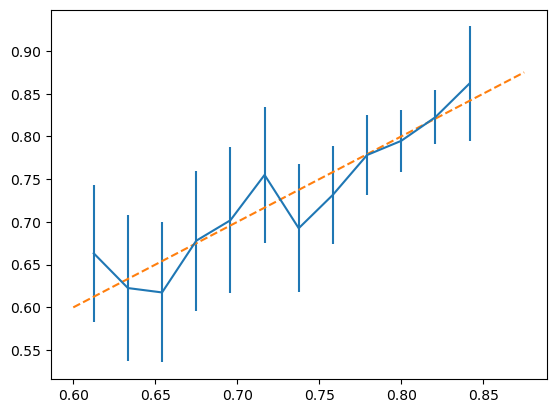

In [46]:

num_bins = 13

nominal_avgs = np.zeros((len(nominal), num_bins))
realized_avgs = np.zeros((len(realized), num_bins))

for i, (n, r, r_b) in enumerate(zip(nominal, realized, realized_b)):
    realized_avg = []
    nominal_avg = []
    n = np.asarray(n)
    r = np.asarray(r)
    for bin_left in np.linspace(0.6, .85, 13):
        ind = np.where((n >= bin_left) & (n <= bin_left + 0.025))[0]
        nominal_avg.append(bin_left + 0.0125)
        realized_avg.append(r[ind].mean())
    nominal_avgs[i] = nominal_avg
    realized_avgs[i] = realized_avg

plt.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 
             1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[1]))
plt.plot(np.linspace(0.6, 0.875, 100), np.linspace(0.6, 0.875, 100), '--')
# plt.savefig("/Users/cherian/Downloads/deleteme.pdf")

4325


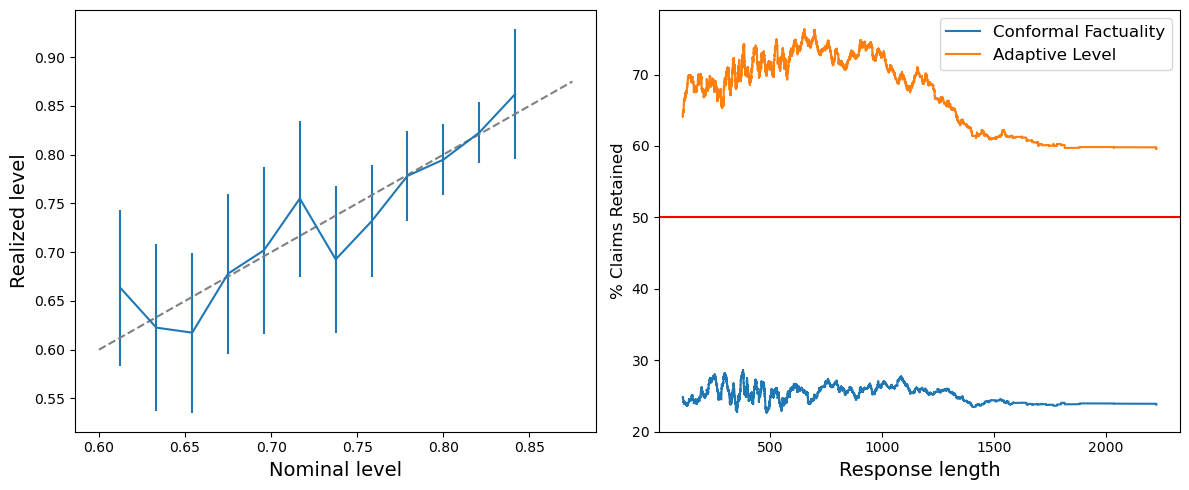

In [50]:

zs_concat = quantile_fn(np.asarray(zs).reshape(-1, 5)).flatten()   
zs_concat = np.asarray(zs).reshape(-1,5)[:,1].flatten()
# zs_concat = quantile_fn(zs).flatten()

# Function to compute the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 5000
sorted_ind = np.argsort(zs_concat)
sorted_percents = np.asarray(percents)[sorted_ind]
sorted_percents_b = np.asarray(percents_b)[sorted_ind]

sorted_zs = zs_concat[sorted_ind]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[1]))
ax1.plot(np.linspace(0.6, 0.875, 100), np.linspace(0.6, 0.875, 100), '--', color='grey')
ax1.set_xlabel("Nominal level", fontsize=14)
ax1.set_ylabel("Realized level", fontsize=14)

ax2.plot(sorted_zs[window_size - 1:], 
         moving_average(100 * sorted_percents_b, window_size), label="Conformal Factuality")
ax2.plot(sorted_zs[window_size - 1:], 
         moving_average(100 * sorted_percents, window_size), label="Adaptive Level")

ax2.axhline(50, color='red')
ax2.set_xlabel("Response length", fontsize=14)
ax2.set_ylabel("% Claims Retained", fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("/Users/cherian/Downloads/deleteme.pdf")
plt.savefig("figures/medlfqa_claim_calibration_retention.pdf")
print(len(ind_conf))

In [162]:
# need to boost now...
# features to boost on: logprobs_arr, selfevals_arr, ordinals_arr

import torch
from scipy.optimize import linprog

def get_current_basis(primals, duals, Phi, S, quantile):
    interp_bools = np.logical_and(~np.isclose(duals, quantile - 1),~np.isclose(duals, quantile))
    if np.sum(interp_bools) == Phi.shape[1]:
        return interp_bools
    preds = (Phi @ primals).flatten()
    active_indices = np.where(interp_bools)[0]
    interp_indices = np.argsort(np.abs(S - preds))[0:Phi.shape[1]]
    diff_indices = np.setdiff1d(interp_indices, active_indices)
    num_missing = Phi.shape[1] - np.sum(interp_bools)
    if num_missing < len(diff_indices):
        from itertools import combinations
        for cand_indices in combinations(diff_indices, num_missing):
            cand_phi = Phi[np.concatenate((active_indices, cand_indices))]
            if np.isfinite(np.linalg.cond(cand_phi)):
                interp_bools[np.asarray(cand_indices)] = True
                break
    else:
        interp_bools[diff_indices] = True
    return interp_bools
            
def solve_qr(Phi, s, q, dtype):
    S = s.detach().numpy()
    zeros = np.zeros((Phi.shape[1],))
    bounds = [(q - 1, q)] * len(S)
    res = linprog(-1 * S, A_eq=Phi.T, b_eq=zeros, bounds=bounds,
                    method='highs-ds', options={'presolve': False})

    tau = -1 * res.eqlin.marginals

    basis = get_current_basis(tau, res.x, Phi, S, q)
    
    tau = as_tensor(np.linalg.inv(Phi[basis].T @ Phi[basis]) @ Phi[basis].T, dtype=dtype) @ s[basis]
    return tau.reshape(-1,1)

def as_tensor(x, dtype, requires_grad=False):
    return torch.tensor(x, dtype=dtype, requires_grad=requires_grad)
    
def cond_score_length(beta, dataset, z, rng, q=0.9):
    data_train, data_calib, ind_train, ind_calib = split_dataset(dataset, rng)
    x_train, y_train = data_train
    x_calib, y_calib = data_calib

    z_train = z[ind_train]
    z_calib = z[ind_calib]
    
    scores_train = torch_score_func(x_train, y_train, beta, method=0)

    Phi_fn = lambda x : x

    # scores_aug = torch.cat((scores_train, torch.tensor([1e5])))
    # cutoffs = torch.zeros((len(z_calib),), dtype=beta.dtype)
    # for i, z_c in enumerate(z_calib):
    #     z_aug = np.concatenate((z_train, z_c.reshape(1,-1)), axis=0)
    #     try:
    #         tau = solve_qr(z_aug, scores_aug, q, beta.dtype)
    #     except:
    #         print("gradient broke")
    #         tau = torch.zeros((len(z_c),), dtype=beta.dtype)
    #     cutoffs[i] = as_tensor(z_c, dtype=beta.dtype) @ tau
    
    # replace cutoff computation with quantile regression
    phi_train = Phi_fn(z_train)
    try:
        tau = solve_qr(phi_train, scores_train, q, beta.dtype)
    except:
        print("gradient broke")
        tau = torch.zeros((phi_train.shape[1],), dtype=beta.dtype)

    phi_calib = Phi_fn(z_calib)
    cutoffs = torch.flatten(as_tensor(phi_calib, dtype=beta.dtype) @ tau)

    total = torch.zeros(1, requires_grad=True)
    for x_c, cutoff in zip(x_calib, cutoffs):
        perc = torch.sigmoid((cutoff - torch.abs(torch.as_tensor(x_c, dtype=beta.dtype) @ beta)))
        total = total + torch.mean(perc) / len(cutoffs)

    return total, (x_calib, cutoffs), tau

def torch_score_func(features, annotations, beta, method):
    scores = as_tensor(np.zeros((len(features),)), dtype=beta.dtype)
    for i, (f, a) in enumerate(zip(features, annotations)):
        cs = torch.abs(as_tensor(f, dtype=beta.dtype) @ beta)
        at = as_tensor(a, dtype=bool)
        scores[i] = torch.sort(cs[~at], descending=True)[0][method] if torch.sum(~at) > method else -1
    return scores
    
rng = np.random.default_rng(seed=0)
features_arr = [np.concatenate((f_arr.reshape(-1,1), s_arr.reshape(-1,1), l_arr.reshape(-1,1) / l_arr.max(),
                               o_arr.reshape(-1,1)), axis=1)
                for f_arr, s_arr, l_arr, o_arr in zip(frequencies_arr, selfevals_arr, logprobs_arr, ordinal_arr)]

dataset = (features_arr, annotations_arr)
# split dataset
data_alpha, data_conf, ind_alpha, ind_conf = split_dataset(dataset, rng, train_frac=0.3)
z_alpha = z_arr_dummies[ind_alpha]

beta_cond = torch.tensor(np.asarray([0.25,0.25,0.25,0.25]), dtype=torch.float, requires_grad=True)

# beta_cond = torch.tensor(np.asarray([0.33,0.33,0.33]), dtype=torch.float, requires_grad=True)
print(beta_cond)
optimizer = torch.optim.Adam([beta_cond])

obj_percs = []
# true_lengths = []
# n_eval = 1000
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    perc, (x_calib, cutoffs), tau = cond_score_length(beta_cond, data_alpha, z_alpha, rng)
    perc.backward()
    optimizer.step()
    obj_percs.append(perc.detach())
    if i % 100 == 0:
        # true_error, true_error_baseline = estimate_true_error_cond(rng, 0.95, n_eval, p, beta_cond.detach().numpy())
        # print(f"iteration {i}", true_error - true_error_baseline)
        # true_lengths.append(true_error - true_error_baseline)
        print(obj_percs[-1], beta_cond, beta_cond.grad)
print(beta_cond, perc)

tensor([0.2500, 0.2500, 0.2500, 0.2500], requires_grad=True)


  0%|▏                                                                            | 2/1000 [00:00<03:55,  4.24it/s]

tensor([0.6597]) tensor([0.2510, 0.2510, 0.2510, 0.2490], requires_grad=True) tensor([-0.0704, -0.0021, -0.0047,  0.3489])


  4%|███                                                                         | 40/1000 [00:07<02:35,  6.19it/s]

gradient broke


 10%|███████▋                                                                   | 102/1000 [00:16<02:21,  6.36it/s]

tensor([0.6363]) tensor([0.3170, 0.2786, 0.2838, 0.1424], requires_grad=True) tensor([-0.1002, -0.0111, -0.0074,  0.7975])


 14%|██████████▎                                                                | 138/1000 [00:22<02:07,  6.74it/s]

gradient broke


 20%|███████████████▏                                                           | 202/1000 [00:34<02:43,  4.87it/s]

tensor([0.5170]) tensor([0.3699, 0.2998, 0.2968, 0.0147], requires_grad=True) tensor([-0.0133,  0.0067, -0.0019,  1.2338])


 30%|██████████████████████▋                                                    | 302/1000 [00:50<01:50,  6.35it/s]

tensor([0.5104]) tensor([0.3414, 0.2878, 0.2836, 0.0037], requires_grad=True) tensor([ 0.0248, -0.0044,  0.0064,  0.2791])


 40%|██████████████████████████████▏                                            | 402/1000 [01:06<01:32,  6.45it/s]

tensor([0.5095]) tensor([0.3006, 0.2861, 0.2626, 0.0064], requires_grad=True) tensor([ 0.0274, -0.0117,  0.0063,  0.4054])


 50%|█████████████████████████████████████▋                                     | 502/1000 [01:21<01:17,  6.45it/s]

tensor([0.5079]) tensor([0.2561, 0.2834, 0.2406, 0.0045], requires_grad=True) tensor([ 0.0281,  0.0014,  0.0080, -0.4384])


 60%|█████████████████████████████████████████████▏                             | 602/1000 [01:37<01:03,  6.31it/s]

tensor([0.5084]) tensor([ 0.2058,  0.2728,  0.2151, -0.0038], requires_grad=True) tensor([ 0.0167,  0.0082,  0.0105, -0.0925])


 70%|████████████████████████████████████████████████████                       | 695/1000 [01:52<00:44,  6.78it/s]

gradient broke


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [01:53<00:47,  6.31it/s]

tensor([0.5066]) tensor([0.1702, 0.2755, 0.2029, 0.0032], requires_grad=True) tensor([ 0.0245, -0.0035,  0.0085,  0.5062])


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [02:09<00:31,  6.33it/s]

tensor([0.5055]) tensor([0.1331, 0.2568, 0.1777, 0.0022], requires_grad=True) tensor([ 2.8928e-02, -5.5401e-03, -1.3531e-04,  1.1576e+00])


 90%|███████████████████████████████████████████████████████████████████▋       | 902/1000 [02:25<00:15,  6.39it/s]

tensor([0.5037]) tensor([0.0905, 0.2277, 0.1459, 0.0024], requires_grad=True) tensor([ 0.0147, -0.0118,  0.0065,  1.6270])


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [02:40<00:00,  6.22it/s]

tensor([0.0461, 0.1889, 0.1142, 0.0008], requires_grad=True) tensor([0.5026], grad_fn=<AddBackward0>)


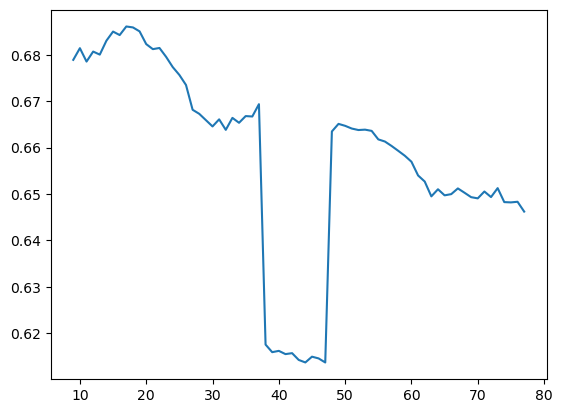

In [161]:
window_size = 10
plt.plot(np.arange(len(obj_percs))[window_size - 1:], moving_average(np.asarray(obj_percs).flatten(), window_size))

In [32]:
scores_arr_alpha = [f @ beta_cond.detach().numpy() for f in data_alpha[0]]
scores_arr_conf = [f @ beta_cond.detach().numpy() for f in data_conf[0]]

n_trials = 50
all_covs_jc = np.zeros((n_trials, 1 + len(dataset_names)))
all_claims_jc = np.zeros((n_trials, 1 + len(dataset_names)))

rng = np.random.default_rng(seed=0)
k = 0
quantile = 0.9

scores_arr_alpha = [score + rng.uniform(low=0, high=1e-3, size=score.shape) for score in scores_arr_alpha]
scores_arr_jitter = [score + rng.uniform(low=0, high=1e-3, size=score.shape) for score in scores_arr_conf]
rng = np.random.default_rng(seed=1)
for trial in tqdm(range(n_trials)):
    all_covs_jc[trial], all_claims_jc[trial] = run_coverage_trial(scores_arr_jitter, data_conf[1], z_arr_dummies[ind_conf], rng, k, quantile)

 32%|████████████████████████▉                                                     | 16/50 [00:24<00:53,  1.57s/it]

hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm
hmmm


 32%|████████████████████████▉                                                     | 16/50 [01:05<02:18,  4.07s/it]

hmmm
hmmm


KeyboardInterrupt: 

0.40735842351842266 0.29837547899406525


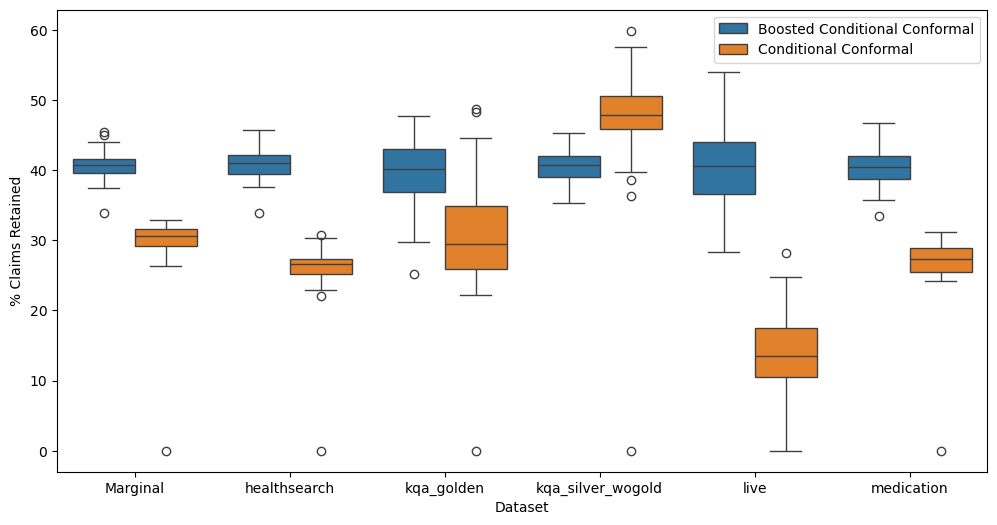

In [13]:
# Create a DataFrame for each method
names = ["Marginal"] + dataset_names
indices_to_plot = np.arange(len(names))

names = [names[i] for i in indices_to_plot]
df1 = pd.DataFrame(all_claims_jc[:,indices_to_plot] * 100, columns=names)
df2 = pd.DataFrame(all_claims[:,indices_to_plot] * 100, columns=names)

# Add a column to identify the method
df1['Method'] = 'Boosted Conditional Conformal'
df2['Method'] = 'Conditional Conformal'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted = df.melt(id_vars='Method', var_name='Dataset', value_name='% Claims Retained')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dataset', y='% Claims Retained', hue='Method', data=df_melted)
# Customize the plot
plt.legend()
# plt.savefig('figures/medlfqa_boosting.pdf')
print(np.mean(all_claims_jc[:,0]), np.mean(all_claims[:,0]))

In [146]:
scores_calib

array([ 0.34774587,  0.36119461, -1.        , -1.        ,  0.34487024,
       -1.        , -1.        ,  0.3042061 , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
        0.29293068,  0.34014217, -1.        , -1.        , -1.        ,
       -1.        , -1.        ,  0.19024353, -1.        , -1.        ,
        0.34677725, -1.        , -1.        , -1.        ,  0.32508499,
       -1.        ,  0.32306593, -1.        , -1.        , -1.        ,
       -1.        , -1.        ,  0.30444597, -1.        ,  0.33025604,
        0.24015407,  0.33010499,  0.34697925, -1.        , -1.        ,
       -1.        , -1.        , -1.        ,  0.34947717, -1.        ,
       -1.        , -1.        , -1.        ,  0.32379747, -1.        ,
       -1.        ,  0.36629645,  0.3495625 , -1.        ,  0.15512373,
       -1.        ,  0.29259029,  0.34145623,  0.25639536,  0.25784327,
       -1.        ,  0.26752768,  0.34772246, -1.        , -1.  

In [45]:
## now I should try to estimate the alpha at which the conditional conformal method retains 70% of the claims

def index_dataset(dataset, ind):
    x_vals = [dataset[0][i] for i in ind]
    y_vals = [dataset[1][i] for i in ind]
    return (x_vals, y_vals)
    
rng = np.random.default_rng(seed=0)
k = 0

# dataset = (scores_arr_jitter, annotations_arr)
data_alpha = (scores_arr_alpha, data_alpha[1])
data_conf = (scores_arr_jitter, data_conf[1])

dataset_b = (frequencies_arr_jitter, annotations_arr)
# split dataset
data_conf_b = index_dataset(dataset_b, ind_conf)

phi_alpha = lambda x: x 

# use data alpha to estimate critical alpha for which fact retention goal is achieved
data_calib, data_test, ind_calib, ind_test = split_dataset(data_alpha, rng, train_frac=0.5)
ind_calib = ind_alpha[ind_calib]
ind_test = ind_alpha[ind_test]
z_calib = z_arr_dummies[ind_calib]
z_test = z_arr_dummies[ind_test]

scores_calib = score_func(*data_calib, method=k)

scores_calib += rng.uniform(0, 1e-5, size=(len(scores_calib),))

x_test, y_test = data_test
n_grid = 50
percents = np.empty((n_grid, len(x_test)))

condconf = CondConf(lambda x,y: y, phi_alpha)
condconf.setup_problem(z_calib, scores_calib)

quantile_grid = np.linspace(0.20, 0.99, 50)
i = 0
for q in tqdm(quantile_grid):
    perc_q = []
    for x_t, z_t in zip(x_test, z_test):
        try:
            cutoff = condconf.predict(quantile=q, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=False)
        except ValueError as e:
            print("dataset too small probably")
            raise ValueError(e)
            cutoff = [np.inf]
        perc_q.append(get_retained_claims([x_t], cutoff)[0])
    percents[i] = perc_q
    i += 1 


perc_booleans = percents >= 0.7

first_violating_indices = np.argmax(~perc_booleans, axis=0) - 1
first_violating_indices[~np.any(~perc_booleans, axis=0)] = -1  # Use -1 to indicate no False found

max_quantiles = quantile_grid[first_violating_indices]

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [01:59<00:00,  2.40s/it]


(9, 1) [[1.00000000e+00]
 [2.56000000e+02]
 [3.10000000e+01]
 [9.80715533e-01]
 [5.18757079e-02]
 [1.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
(721, 9)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


[(0.5, 0.564204593726688),
 (0.564204593726688, 0.6149318666199982),
 (0.6149318666199982, 0.6603842744319879),
 (0.6603842744319879, 0.698819207724569),
 (0.698819207724569, 0.7324516230549323),
 (0.7324516230549323, 0.7531983574957203),
 (0.7531983574957203, 0.7665342144316086),
 (0.7665342144316086, 0.7811020257785305),
 (0.7811020257785305, 0.8016185091916592),
 (0.8016185091916592, 0.8573900371614037)]

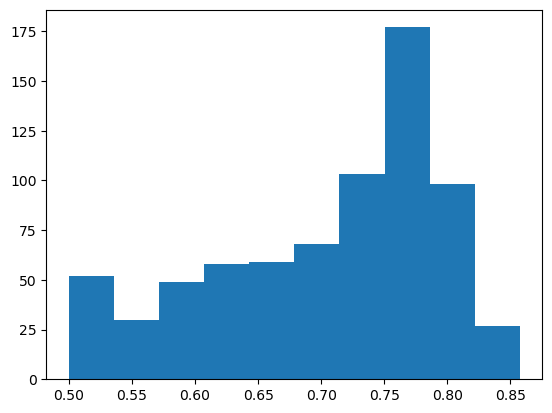

In [46]:
phi_alpha_fun = lambda x : x#x[:, :-4]
condconf_alpha = CondConf(score_fn = lambda x, y: y, Phi_fn = phi_alpha_fun)
condconf_alpha.setup_problem(z_test, max_quantiles)

q = 5
_, primals = condconf_alpha._get_calibration_solution(quantile=q/100)
print(primals.shape, phi_alpha_fun(z_test[0].reshape(-1,1)))
quantile_fn = lambda x: np.clip(phi_alpha_fun(x) @ primals, a_min=0.5, a_max=0.99)
z_to_plot = phi_alpha(z_test)[:,-5] 

sorted_ind = np.argsort(z_to_plot)

# plt.plot(z_to_plot[sorted_ind],1 - quantile_fn(z_test)[sorted_ind], color='black', linewidth=3)
# plt.scatter(z_to_plot, 1 - max_quantiles, alpha=0.2)
# plt.xscale("log")
# plt.xlabel("Z", fontsize=14)
# plt.ylabel(r"$\alpha^*$", fontsize=14)
# plt.savefig("/Users/cherian/Downloads/deleteme.pdf")
# plt.savefig("figures/factscore_alpha_est.pdf")
plt.figure()
print(z_test.shape)
plt.hist(quantile_fn(z_test)[sorted_ind])
print(np.linspace(0, 1, 11))
bin_edges = np.quantile(quantile_fn(z_test).flatten(), np.linspace(0, 1, 11))

candidate_bins = [(b, b_plus) for b, b_plus in zip(bin_edges, bin_edges[1:])]
candidate_bins

In [57]:
quantile_bins = np.linspace(0.0, 0.95, 20)
quantile_bins

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [144]:
seed = 1
k = 0
n_seeds = 100
nominal = []
realized = []
percents = []
zs = []

realized_jc = []
percents_jc = []

realized_b = []
percents_b = []

dataset_covs = np.zeros((n_seeds, len(dataset_names)))
dataset_claims = np.zeros((n_seeds, len(dataset_names)))

dataset_covs_jc = np.zeros((n_seeds, len(dataset_names)))
dataset_claims_jc = np.zeros((n_seeds, len(dataset_names)))

dataset_covs_b = np.zeros((n_seeds, len(dataset_names)))
dataset_claims_b = np.zeros((n_seeds, len(dataset_names)))

def bin_fn(x, left, right):
    indics = (x <= right) & (x >= left)
    return indics.astype(np.float32)

for seed in tqdm(range(n_seeds)):
    rng = np.random.default_rng(seed=seed)
    
    data_calib, data_test, ind_calib, ind_test = split_dataset(data_conf, rng, train_frac=0.7) # used to be 0.06
    data_calib_b = index_dataset(data_conf_b, ind_calib)
    data_test_b = index_dataset(data_conf_b, ind_test)

    ind_calib = ind_conf[ind_calib]
    ind_test = ind_conf[ind_test]
    
    ind_test = ind_test[0:500]
    z_calib = z_arr_dummies[ind_calib]
    z_test = z_arr_dummies[ind_test]
    dataset_dummies_test = dataset_dummies.to_numpy()[ind_test]
    
    x_calib, y_calib = data_calib
    scores_calib = score_func(*data_calib, method=k)
    scores_calib_b = score_func(*data_calib_b, method=k)
    
    score_fn = lambda x, y: y
    phi_fn_jc = lambda x : x
    
    quantile_bins = np.linspace(0.5, 1.0, 11)
    active_quantiles = quantile_fn(z_calib).flatten()

    active_bins = []
    for q_lower, q_upper in zip(quantile_bins, quantile_bins[1:]):
        inds = np.where((active_quantiles <= q_upper) & (active_quantiles >= q_lower))[0]
        if len(inds) > 5:
            active_bins.append((q_lower, q_upper))

    phi_fn = lambda x: np.concatenate(
        (
            # x[:,1:],
            x,
            quantile_fn(x)**2,
            quantile_fn(x)**3
            # *(bin_fn(quantile_fn(x), b[0], b[1]).reshape(-1,1) for b in active_bins)
        ),
        axis=1
    )

    condconf = CondConf(score_fn = score_fn, Phi_fn = phi_fn, quantile_fn = quantile_fn)
    condconf.setup_problem(z_calib, scores_calib)

    condconf_jc = CondConf(score_fn = score_fn, Phi_fn = phi_fn_jc, quantile_fn = quantile_fn)
    condconf_jc.setup_problem(z_calib, scores_calib)

    condconf_b = CondConf(score_fn = score_fn, Phi_fn = lambda x : np.ones((len(x), 1)))
    condconf_b.setup_problem(z_calib, scores_calib_b)

    quantiles_calib = quantile_fn(z_calib)
    
    x_test, y_test = data_test
    x_test_b, y_test_b = data_test_b
    scores_test = score_func(*data_test, method=k)
    scores_test_b = score_func(*data_test_b, method=k)
    percs = []
    percs_jc = []
    percs_b = []
    thresholds = []
    thresholds_jc = []
    thresholds_b = []
    for x_t, z_t, s_t, xb_t in zip(x_test, z_test, scores_test, x_test_b):
        try:
            threshold = condconf.predict(quantile=None, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except ValueError as e:
            raise ValueError(e)
            threshold = [np.inf]
            
        try:
            threshold_jc = condconf_jc.predict(quantile=0.9, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except:
            threshold_jc = [np.inf]
            
        try:
            threshold_b = condconf_b.predict(quantile=0.9, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except:
            threshold_b = [np.inf]
        percs.append(get_retained_claims([x_t], threshold)[0])
        thresholds.append(threshold)
        percs_jc.append(get_retained_claims([x_t], threshold_jc)[0])
        thresholds_jc.append(threshold_jc)
        percs_b.append(get_retained_claims([xb_t], threshold_b)[0])
        thresholds_b.append(threshold_b)
    realized.append([s <= t for s, t in zip(scores_test, thresholds)])
    percents.extend(percs)
    realized_jc.append([s <= t for s, t in zip(scores_test, thresholds_jc)])
    percents_jc.extend(percs_jc)
    realized_b.append([s <= t for s, t in zip(scores_test_b, thresholds_b)])
    percents_b.extend(percs_b)
    
    zs.append(z_test)
    nominal.append(condconf.quantile_fn(z_test))

    for d_idx in range(len(dataset_names)):
        dataset_cov = np.sum(dataset_dummies_test[:,d_idx] * np.asarray(realized[-1]).flatten()) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_covs[seed,d_idx] = dataset_cov
        dataset_perc = np.sum(dataset_dummies_test[:,d_idx] * percs) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_claims[seed,d_idx] = dataset_perc

    for d_idx in range(len(dataset_names)):
        dataset_cov = np.sum(dataset_dummies_test[:,d_idx] * np.asarray(realized_b[-1]).flatten()) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_covs_b[seed,d_idx] = dataset_cov
        dataset_perc = np.sum(dataset_dummies_test[:,d_idx] * percs_b) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_claims_b[seed,d_idx] = dataset_perc
        
    for d_idx in range(len(dataset_names)):
        dataset_cov = np.sum(dataset_dummies_test[:,d_idx] * np.asarray(realized_jc[-1]).flatten()) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_covs_jc[seed,d_idx] = dataset_cov
        dataset_perc = np.sum(dataset_dummies_test[:,d_idx] * percs_jc) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_claims_jc[seed,d_idx] = dataset_perc

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [03:26<00:00,  2.06s/it]


  0%|                                                                                      | 0/100 [00:00<?, ?it/s]/var/folders/2c/q6mwmmzj2ql08r9nph0mbnwr0000gn/T/ipykernel_8867/4065927971.py:27: RuntimeWarning: Mean of empty slice.
  realized_avg.append(r[ind].mean())
100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 283.87it/s]


[ 0.01813596 -0.02121596  0.00393627  0.01518269  0.01861215 -0.00822124
 -0.0212187          nan]
[ 0.09121825 -0.13530123  0.04349323 -0.02226587  0.10859534 -0.02417392
 -0.04335642         nan]
[ 0.00459463 -0.00699949 -0.02847128  0.0095972   0.00612653]


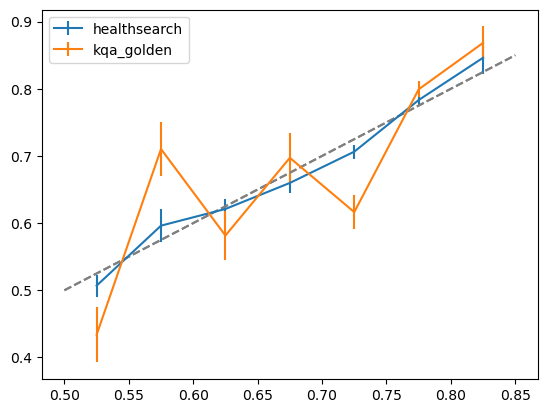

In [145]:
group_nominal_avgs = np.zeros((2, len(nominal), len(active_bins)))
group_realized_avgs = np.zeros((2, len(nominal), len(active_bins)))

for i in tqdm(range(n_seeds)):
    rng = np.random.default_rng(seed=i)
    
    data_calib, data_test, ind_calib, ind_test = split_dataset(data_conf, rng, train_frac=0.7) # used to be 0.06
    data_calib_b = index_dataset(data_conf_b, ind_calib)
    data_test_b = index_dataset(data_conf_b, ind_test)

    ind_calib = ind_conf[ind_calib]
    ind_test = ind_conf[ind_test]
    
    ind_test = ind_test[0:500]
    z_calib = z_arr_dummies[ind_calib]
    z_test = z_arr_dummies[ind_test]
    dataset_dummies_test = dataset_dummies.to_numpy()[ind_test]

    for j, d_idx in enumerate([0,2]):
        n = nominal[i][dataset_dummies_test[:,d_idx]]
        r = np.asarray(realized[i])[dataset_dummies_test[:,d_idx]]
        realized_avg = []
        nominal_avg = []
        for bin_left, bin_right in active_bins:
            ind = np.where((n >= bin_left) & (n <= bin_right))[0]
            nominal_avg.append((bin_left + bin_right)/2)
            realized_avg.append(r[ind].mean())
        group_nominal_avgs[j, i, :] = nominal_avg
        group_realized_avgs[j, i, :] = realized_avg

for name, nominal_avgs, realized_avgs in zip(dataset_names, group_nominal_avgs, group_realized_avgs):
    print(np.mean(nominal_avgs, axis=0) - np.mean(realized_avgs, axis=0))
    plt.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 
                 1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[0]), label=name)
    plt.plot(np.linspace(0.5, 0.85, 100), np.linspace(0.5, 0.85, 100), '--', color='grey')
    # plt.set_xlabel("Nominal level", fontsize=14)
    # plt.set_ylabel("Realized level", fontsize=14)
plt.legend()
print(0.9 - dataset_covs_b.mean(axis=0))

In [151]:
len(ind_conf), len(ind_calib), len(ind_test)

(3364, 2354, 500)

/var/folders/2c/q6mwmmzj2ql08r9nph0mbnwr0000gn/T/ipykernel_8867/3454156293.py:19: RuntimeWarning: Mean of empty slice.
  realized_avg.append(r[ind].mean())


[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9 ]


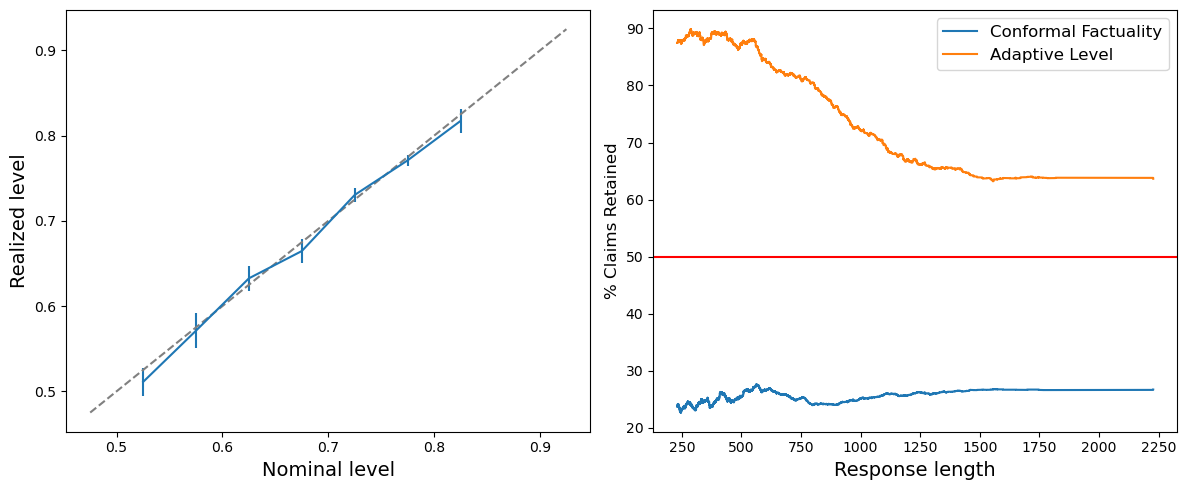

In [85]:
num_bins = len(active_bins) + 1
z_dim = 9
nominal_avgs = np.zeros((len(nominal), num_bins - 1))
realized_avgs = np.zeros((len(realized), num_bins - 1))

for i, (n, r, r_b) in enumerate(zip(nominal, realized, realized_b)):
    realized_avg = []
    nominal_avg = []
    n = np.asarray(n)
    r = np.asarray(r)
    # bins = np.linspace(0.500, 0.9, num_bins)
    # for bin_left, bin_right in zip(bins, bins[1:]):
    #     ind = np.where((n >= bin_left) & (n <= bin_right))[0]
    #     nominal_avg.append((bin_left + bin_right)/2)
    #     realized_avg.append(r[ind].mean())
    for bin_left, bin_right in active_bins:
        ind = np.where((n >= bin_left) & (n <= bin_right))[0]
        nominal_avg.append((bin_left + bin_right)/2)
        realized_avg.append(r[ind].mean())
    nominal_avgs[i] = nominal_avg
    realized_avgs[i] = realized_avg


zs_concat = quantile_fn(np.asarray(zs).reshape(-1, z_dim)).flatten()   
zs_concat = np.asarray(zs).reshape(-1,z_dim)[:,1].flatten()
# zs_concat = quantile_fn(zs).flatten()

# Function to compute the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 5000
sorted_ind = np.argsort(zs_concat)
sorted_percents = np.asarray(percents)[sorted_ind]
sorted_percents_b = np.asarray(percents_b)[sorted_ind]

sorted_zs = zs_concat[sorted_ind]

min_bin = np.min(bins) - 0.025
max_bin = np.max(bins) + 0.025

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 
             1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[0]))
ax1.plot(np.linspace(min_bin, max_bin, 100), np.linspace(min_bin, max_bin, 100), '--', color='grey')
ax1.set_xlabel("Nominal level", fontsize=14)
ax1.set_ylabel("Realized level", fontsize=14)

ax2.plot(sorted_zs[window_size - 1:], 
         moving_average(100 * sorted_percents_b, window_size), label="Conformal Factuality")
ax2.plot(sorted_zs[window_size - 1:], 
         moving_average(100 * sorted_percents, window_size), label="Adaptive Level")

ax2.axhline(50, color='red')
ax2.set_xlabel("Response length", fontsize=14)
ax2.set_ylabel("% Claims Retained", fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("figures/medlfqa_claim_calibration_retention.pdf")
print(bins)

10


([<matplotlib.axis.XTick at 0x13c562930>,
 [Text(1, 0, '0.705'),
  Text(2, 0, '0.715'),
  Text(3, 0, '0.725'),
  Text(4, 0, '0.735'),
  Text(5, 0, '0.745'),
  Text(6, 0, '0.755'),
  Text(7, 0, '0.765'),
  Text(8, 0, '0.775'),
  Text(9, 0, '0.785'),
  Text(10, 0, '0.795')])

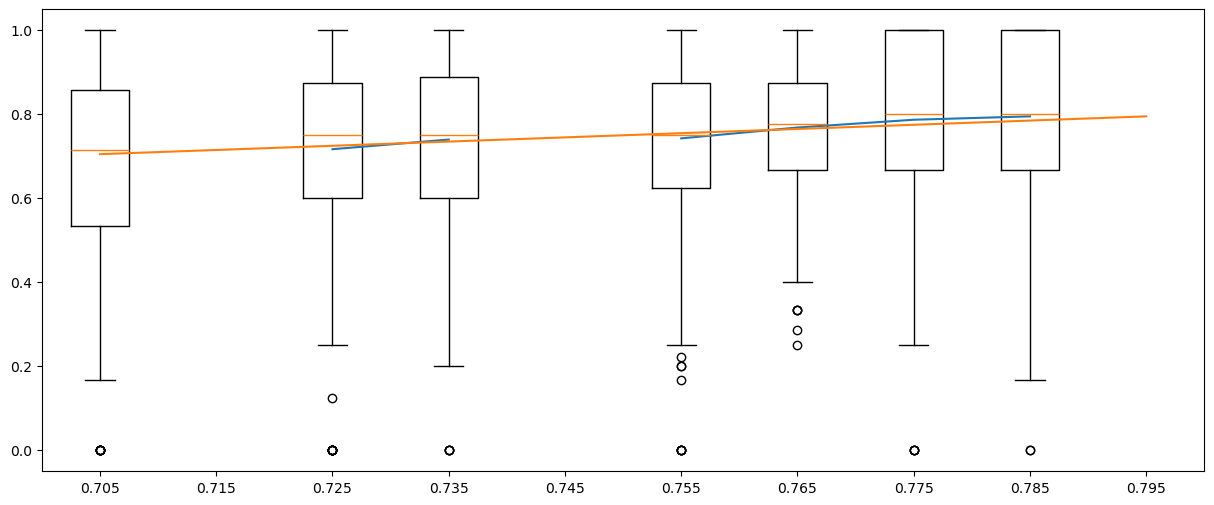

In [44]:
print(realized_avgs.shape[1])
plt.figure(figsize=(15,6))
plt.boxplot([realized_avgs[:,i] for i in range(realized_avgs.shape[1])])
plt.plot(np.arange(1, 1 + (realized_avgs.shape[1])), [np.mean(realized_avgs[:,i]) for i in range(realized_avgs.shape[1])])
plt.plot(np.arange(1, 1 + (realized_avgs.shape[1])), [np.mean(nominal_avgs[:,i]) for i in range(realized_avgs.shape[1])])
plt.xticks(ticks=np.arange(1, 1 + realized_avgs.shape[1]), labels=[np.around(np.mean(nominal_avgs[:,i]), 3) for i in range(realized_avgs.shape[1])])

In [210]:
print(np.linspace(0.55, .85, 13))

[0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825
 0.85 ]


0.3931094530801444 0.24354123660068733


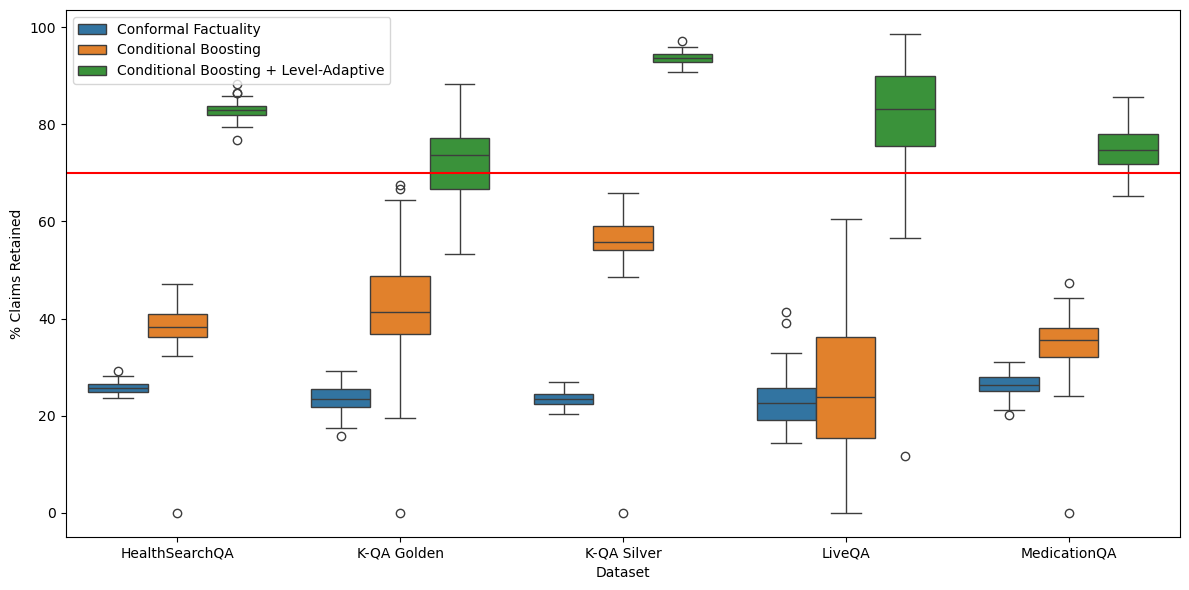

In [89]:
# Create a DataFrame for each method
names = dataset_names
names = ["HealthSearchQA", "K-QA Golden", "K-QA Silver", "LiveQA", "MedicationQA"]
indices_to_plot = np.arange(len(names))

names = [names[i] for i in indices_to_plot]
df1 = pd.DataFrame(dataset_claims_b[:,indices_to_plot] * 100, columns=names)
df2 = pd.DataFrame(dataset_claims_jc[:,indices_to_plot] * 100, columns=names)
df3 = pd.DataFrame(dataset_claims[:,indices_to_plot] * 100, columns=names)

# Add a column to identify the method
df1['Method'] = 'Conformal Factuality'
df2['Method'] = 'Conditional Boosting'
df3['Method'] = 'Conditional Boosting + Level-Adaptive'

# Combine the DataFrames
df = pd.concat([df1, df2, df3])

# Melt the combined DataFrame
df_melted = df.melt(id_vars='Method', var_name='Dataset', value_name='% Claims Retained')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dataset', y='% Claims Retained', hue='Method', data=df_melted)
plt.axhline(70, color='red')

print(np.mean(dataset_claims_jc), np.mean(dataset_claims_b))

# Customize the plot
plt.legend()
plt.tight_layout()
# plt.savefig('figures/medlfqa_boosting.pdf')

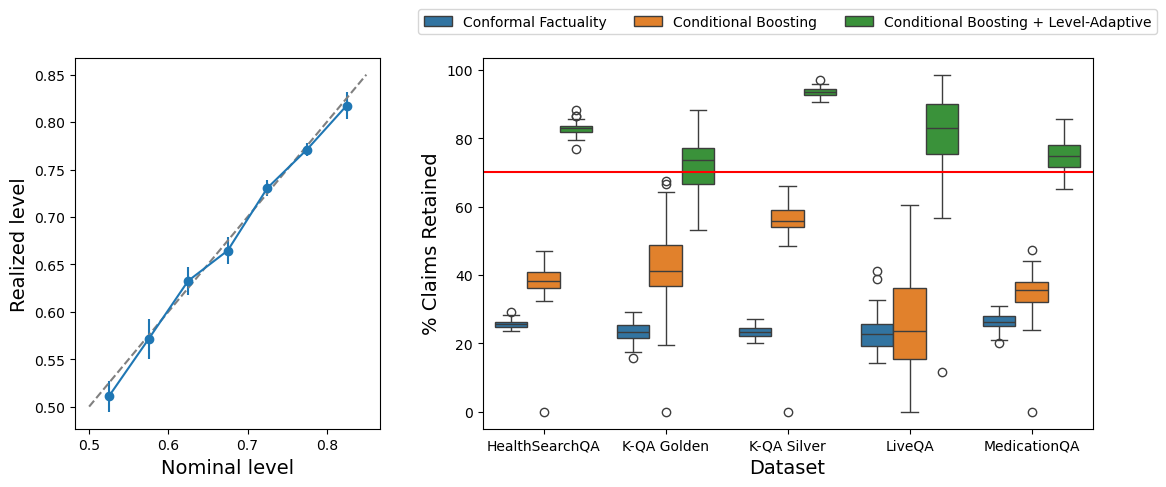

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[1,2])
ax1.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 
             1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[0]), marker='o')
ax1.plot(np.linspace(0.50, 0.85, 100), np.linspace(0.50, 0.85, 100), '--', color='grey')
ax1.set_xlabel("Nominal level", fontsize=14)
ax1.set_ylabel("Realized level", fontsize=14)

sns.boxplot(x='Dataset', y='% Claims Retained', hue='Method', data=df_melted, ax=ax2)
ax2.axhline(70, color='red')
ax2.set_ylabel("% Claims Retained", fontsize=14)

# Customize the plot
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
# ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)
ax2.set_xlabel("Dataset", fontsize=14)
plt.tight_layout()
plt.savefig("figures/medlfqa_intro_validity_final.pdf")


In [82]:
dataset_test = [full_dataset[i] for i in ind_test]

for i, dat in enumerate(dataset_test):
    if 'shingles' in dat['prompt']:
        print(i)
idx = 283
# scores_test[idx], x_test[idx], thresholds[idx], thresholds_b[idx]
print(thresholds[idx], thresholds_b[idx])
for i, af in enumerate(dataset_test[idx]['atomic_facts']):
    af['boosted_score'] = x_test[idx][i]
    if af['boosted_score'] > thresholds[idx]:
        af['retained'] = True
    else:
        af['retained'] = False
    af['score'] = x_test_b[idx][i]
    if af['score'] > thresholds_b[idx]:
        af['retained_cf'] = True
    else:
        af['retained_cf'] = False
        
# dataset_test[idx]['final_threshold'] = thresholds[idx]
# dataset_test[idx]['old_threshold'] = thresholds_b[idx]
dataset_lookup[dataset_test[idx]['prompt']]
dataset_test[idx]
len(ind_calib)

283
285
[0.28318053] [1.00067923]


2354

In [92]:
for name, val in orig_datasets.items():
    print(name, len(val))

medication_qa 627
kqa_golden 201
live_qa 100
healthsearch_qa 3047
kqa_silver_wogold 876
